# IV

## IVデータのロード

### ソースコード

In [1]:
def load_iv_data(file_path: str) -> tuple[list[float], list[float], list[float]]:
    """
    指定したIVファイルを読み込み、Id(mA), Vd(mV), R(ohm)の各リストを返す。

    仕様:
    - 先頭2行は無視
    - 3行目以降を1行ずつ読み取る
    - 各行は7つの値(空白区切り)を想定し、Id(A)=1列目, Vd(V)=2列目, R(ohm)=5列目
    - IdとVdはm単位に変換(×1000)して格納
    - 空行や非数値行(例: "= = = ="やコメント)は自動でスキップ
    """
    id_milliamp: list[float] = []
    vd_millivolt: list[float] = []
    resistance_ohm: list[float] = []

    with open(file_path, "r", encoding="utf-8") as f:
        for line_index, raw_line in enumerate(f, start=1):
            if line_index <= 2:
                continue
            line = raw_line.strip()
            if not line or line.startswith("#"):
                continue

            parts = line.split()  # 空白(スペース/タブ)の複数区切りに対応
            if len(parts) < 5:
                continue

            try:
                id_amp = float(parts[0])
                vd_volt = float(parts[1])
                r_ohm = float(parts[4])
            except ValueError:
                # 非数値行はスキップ
                continue

            id_milliamp.append(id_amp * 1_000.0)
            vd_millivolt.append(vd_volt * 1_000.0)
            resistance_ohm.append(r_ohm)

    return id_milliamp, vd_millivolt, resistance_ohm

# 使用例(必要に応じてパスを設定して実行)
# iv_1_path = "/Users/shimizuryousuke/dev/expdata-plotter/expdata-plotter/sample_data/IV_curve/IV 3-3c 300K Mg8nm SiNmiddle"
# ids_mA, vds_mV, rs_ohm = load_iv_data(iv_1_path)



### 使用例とプレビュー

In [2]:
def preview_iv(ids_mA: list[float], vds_mV: list[float], rs_ohm: list[float], limit: int = 10) -> None:
    """
    IVデータを整形して表示する。

    - 先頭と末尾をそれぞれ `limit` 行まで表示
    - 件数と各列の簡単な統計量(min, max, mean)を併記
    """
    n = min(len(ids_mA), len(vds_mV), len(rs_ohm))
    if n == 0:
        print("No data.")
        return

    # 統計
    def _mean(values: list[float]) -> float:
        return sum(values) / len(values) if values else float("nan")

    id_min, id_max, id_mean = min(ids_mA), max(ids_mA), _mean(ids_mA)
    vd_min, vd_max, vd_mean = min(vds_mV), max(vds_mV), _mean(vds_mV)
    r_min, r_max, r_mean = min(rs_ohm), max(rs_ohm), _mean(rs_ohm)

    print(f"Rows: {n}")
    print(f"Id(mA)  min={id_min:.6f}, max={id_max:.6f}, mean={id_mean:.6f}")
    print(f"Vd(mV)  min={vd_min:.6f}, max={vd_max:.6f}, mean={vd_mean:.6f}")
    print(f"R(ohm)  min={r_min:.6f}, max={r_max:.6f}, mean={r_mean:.6f}")

    header = f"{'idx':>5} {'Id(mA)':>14} {'Vd(mV)':>14} {'R(ohm)':>14}"
    print("\n" + header)
    print("-" * len(header))

    show = min(limit, n)
    for i in range(show):
        print(f"{i:5d} {ids_mA[i]:14.6f} {vds_mV[i]:14.6f} {rs_ohm[i]:14.6f}")

    if n > 2 * limit:
        print("    ...              ...              ...              ...")
        start_tail = n - limit
        for i in range(start_tail, n):
            print(f"{i:5d} {ids_mA[i]:14.6f} {vds_mV[i]:14.6f} {rs_ohm[i]:14.6f}")
    elif n > limit:
        for i in range(limit, n):
            print(f"{i:5d} {ids_mA[i]:14.6f} {vds_mV[i]:14.6f} {rs_ohm[i]:14.6f}")

# サンプル表示
iv_1_path = "/Users/shimizuryousuke/dev/expdata-plotter/expdata-plotter/sample_data/IV_curve/IV 3-3c 300K Mg8nm SiNmiddle"
ids_mA, vds_mV, rs_ohm = load_iv_data(iv_1_path)
preview_iv(ids_mA, vds_mV, rs_ohm, limit=8)



Rows: 101
Id(mA)  min=-89.510900, max=92.790100, mean=0.598798
Vd(mV)  min=-500.024000, max=499.896000, mean=-0.082879
R(ohm)  min=4.893650, max=5.586180, mean=5.491011

  idx         Id(mA)         Vd(mV)         R(ohm)
--------------------------------------------------
    0     -89.510900    -500.024000       5.586180
    1     -87.742300    -489.988000       5.584399
    2     -85.967700    -480.031000       5.583853
    3     -84.174600    -470.025000       5.583929
    4     -82.389500    -460.004000       5.583284
    5     -80.616000    -450.000000       5.582018
    6     -78.829100    -440.051000       5.582342
    7     -77.057400    -430.025000       5.580580
    ...              ...              ...              ...
   93      79.593200     429.866000       5.400788
   94      81.488300     439.863000       5.397867
   95      83.378800     449.892000       5.395760
   96      85.253400     459.861000       5.394049
   97      87.134900     469.841000       5.392110
   98 

## IVデータのプロット

### ソースコード

In [3]:
from typing import Union, Sequence
import matplotlib.pyplot as plt
import math

def plot_iv_rv_by_index(
    label_indices: Union[int, Sequence[int]],
    ids_series: Sequence[Sequence[float]] | None = None,
    vds_series: Sequence[Sequence[float]] | None = None,
    rs_series: Sequence[Sequence[float]] | None = None,
    marker_choice: Union[int, str, Sequence[Union[int, str]]] = 0,
    linestyle_choice: Union[int, str, Sequence[Union[int, str]]] = 0,
    size_choice: Union[int, float, Sequence[Union[int, float]]] = 0.8,
    color_choice: Union[int, str, Sequence[Union[int, str]]] = "auto",
    title_iv: str = "IV",
    title_rv: str = "RV",
    grid: bool = True,
    figsize: tuple[float, float] = (20, 8),
    iv_xlim: tuple[float, float] = (-500, 500),
    iv_ylim: tuple[float, float] | None = None,
    rv_xlim: tuple[float, float] = (-500, 500),
    rv_ylim: tuple[float, float] | None = None,
    legend_labels: Sequence[str] | None = None,
):
    """
    指定したラベル番号(1始まり)のシリーズを用いて、IV (Id vs Vd) と RV (R vs Vd) を描画する。

    - label_indices: 1始まりの番号(例: 1 または [1,3])
    - ids_series, vds_series, rs_series: 各シリーズを格納した配列の配列 (同じ長さ)
      例) ids_series = [ids_1, ids_2, ...]
    - marker_choice / linestyle_choice / size_choice / color_choice:
      単一指定(全系列共通) もしくは シーケンス指定(系列ごと設定)。
      例) marker_choice=["o","s"], color_choice=["tab:blue","tab:red"]
    - color_choice に "auto" を含む場合はその系列は自動配色
    - figsize: 図サイズ
    - iv_xlim/iv_ylim/rv_xlim/rv_ylim: 各プロットのx/y軸範囲 (Noneなら自動)
    - legend_labels: 凡例ラベルのリスト (系列ごとに循環適用)。未指定時は自動ラベル

    戻り値: (fig, ax_iv, ax_rv)
    """
    # 候補リスト
    marker_options: list[str] = ["o", "s", "^", "D", "x", "+", "*", ".", "v", "P", "h"]
    linestyle_options: list[str] = ["-", "--", ":", "-.", "none"]
    size_options: list[float] = [4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0]
    color_options: list[str] = [
        "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple",
        "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "black",
    ]

    def _resolve_from_options(choice, options, *, allow_auto: bool = False):
        if isinstance(choice, int):
            return options[choice % len(options)]
        if isinstance(choice, str):
            if allow_auto and choice == "auto":
                return "auto"
            if choice in options:
                return choice
            return choice
        return options[0]

    def _resolve_size(choice) -> float:
        if isinstance(choice, int):
            return float(size_options[choice % len(size_options)])
        if isinstance(choice, (float,)):
            return float(choice)
        return float(size_options[0])

    def _choice_for_series(choice_or_seq, j: int):
        if isinstance(choice_or_seq, (list, tuple)):
            return choice_or_seq[j % len(choice_or_seq)]
        return choice_or_seq

    # データ整合チェック
    if ids_series is None or vds_series is None or rs_series is None:
        raise ValueError("ids_series, vds_series, rs_series を指定してください")
    if not (len(ids_series) == len(vds_series) == len(rs_series)):
        raise ValueError("ids_series, vds_series, rs_series の長さが一致していません")

    # ラベル番号を 1始まり → 0始まり に変換
    if isinstance(label_indices, int):
        idx_list = [label_indices]
    else:
        idx_list = list(label_indices)
    zero_based_indices = [i - 1 for i in idx_list]

    # 図準備
    fig, (ax_iv, ax_rv) = plt.subplots(1, 2, figsize=figsize, squeeze=True)

    # 描画
    for j, idx in enumerate(zero_based_indices):
        if idx < 0 or idx >= len(ids_series):
            raise IndexError(f"label index {idx+1} は範囲外です (1..{len(ids_series)})")
        ids = ids_series[idx]
        vds = vds_series[idx]
        rs = rs_series[idx]

        # 系列ごとのスタイル解決
        marker_j = _resolve_from_options(_choice_for_series(marker_choice, j), marker_options)
        linestyle_j = _resolve_from_options(_choice_for_series(linestyle_choice, j), linestyle_options)
        size_j = _resolve_size(_choice_for_series(size_choice, j))
        color_sel = _choice_for_series(color_choice, j)
        color_j = _resolve_from_options(color_sel, color_options, allow_auto=True)
        if color_j == "auto":
            color_j = color_options[j % len(color_options)]

        # ラベル: 指定があれば循環適用、なければ自動
        if legend_labels and len(legend_labels) > 0:
            label = legend_labels[j % len(legend_labels)]
        else:
            label = f"label {idx+1}"

        # 【修正点2】plotとscatterを1つのplot関数に統合し、重複描画を防止
        # IV: Id(mA) vs Vd(mV)
        ax_iv.plot(
            vds, ids,
            linestyle=linestyle_j,
            marker=marker_j,
            markersize=size_j,  # plotではmarkersizeを指定
            color=color_j,
            linewidth=1.2,
            alpha=0.9,
            label=label
        )

        # 【修正点1】RVプロット用にvds=0のデータ点を除外
        filtered_pairs = [(v, r) for v, r in zip(vds, rs) if not (-50 <= v <= 50)]
        if filtered_pairs:
            # フィルタリングされたデータがある場合のみプロット
            vds_rv, rs_rv = zip(*filtered_pairs)
            
            # 【修正点2】plotとscatterを1つのplot関数に統合し、重複描画を防止
            # RV: R(ohm) vs Vd(mV)
            ax_rv.plot(
                vds_rv, rs_rv,
                linestyle=linestyle_j,
                marker=marker_j,
                markersize=size_j, # plotではmarkersizeを指定
                color=color_j,
                linewidth=1.2,
                alpha=0.9,
                label=label
            )

    # 軸や体裁
    ax_iv.set_title(title_iv)
    ax_iv.set_xlabel("Vd (mV)", fontsize=17)
    ax_iv.set_ylabel("Id (mA)", fontsize=17)
    ax_iv.tick_params(labelsize=17, direction="in")

    ax_rv.set_title(title_rv)
    ax_rv.set_xlabel("Vd (mV)", fontsize=17)
    ax_rv.set_ylabel("R (ohm)", fontsize=17)
    ax_rv.set_yscale("log")
    ax_rv.tick_params(labelsize=17, direction="in")
    # 縦横比を1:1（正方形）に固定
    ax_iv.set_box_aspect(1)
    ax_rv.set_box_aspect(1)
    

    # 軸範囲の適用（指定があれば）
    if iv_xlim is not None: ax_iv.set_xlim(iv_xlim)
    if iv_ylim is not None: ax_iv.set_ylim(iv_ylim)
    if rv_xlim is not None: ax_rv.set_xlim(rv_xlim)
    if rv_ylim is not None: ax_rv.set_ylim(rv_ylim)

    if grid:
        ax_iv.grid(True, linestyle=":", alpha=0.4)
        ax_rv.grid(True, linestyle=":", alpha=0.4)

    # 凡例の列数を計算 (1列あたり6個まで)
    num_plots = len(zero_based_indices)
    legend_cols = math.ceil(num_plots / 6) if num_plots > 0 else 1
    
    # 凡例ハンドルが生成されている場合のみ凡例を表示
    if any(ax_iv.get_legend_handles_labels()[0]):
        ax_iv.legend(frameon=False, fontsize=13, ncol=legend_cols)
    if any(ax_rv.get_legend_handles_labels()[0]):
        ax_rv.legend(frameon=False, fontsize=13, ncol=legend_cols)

    fig.tight_layout()
    return fig, ax_iv, ax_rv

### 使用例

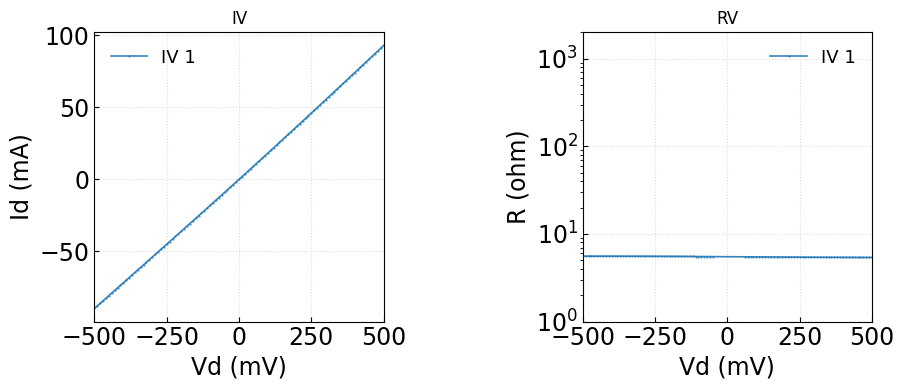

In [4]:
# サンプル: いま読み込んだ単一データを 1 番ラベルとして描画
try:
    _ids_series = [ids_mA]
    _vds_series = [vds_mV]
    _rs_series = [rs_ohm]
    plot_iv_rv_by_index(
        label_indices=1,
        ids_series=_ids_series,
        vds_series=_vds_series,
        rs_series=_rs_series,
        legend_labels=["IV 1", "IV 2", "IV 3"],
        iv_xlim=(-500, 500),
        rv_xlim=(-500, 500),
        rv_ylim=(1, 2000),
        marker_choice=0,        # or [0, 1, ...]
        linestyle_choice=0,     # or ["-", "--", ...]
        size_choice=0.5,          # or [2, 3, ...]
        color_choice="auto",   # or ["tab:blue", "tab:red", ...]
        title_iv="IV",
        title_rv="RV",
        grid=True,
        figsize=(10, 4),
    )
except NameError:
    pass

(<Figure size 1000x400 with 2 Axes>,
 <Axes: title={'center': 'IV'}, xlabel='Vd (mV)', ylabel='Id (mA)'>,
 <Axes: title={'center': 'RV'}, xlabel='Vd (mV)', ylabel='R (ohm)'>)

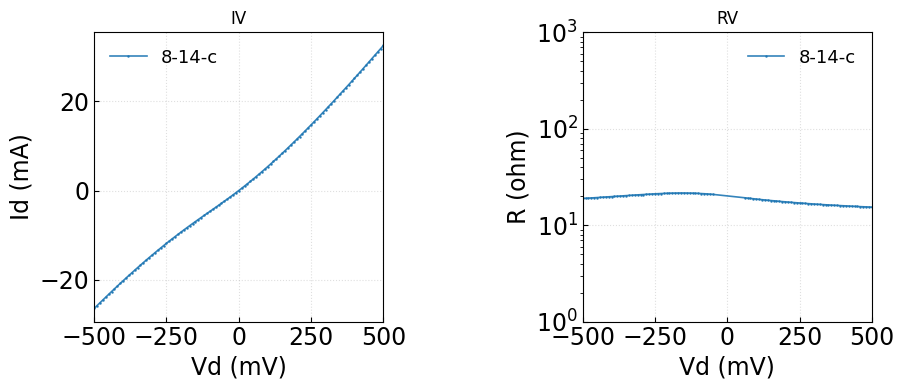

In [5]:
file_path = '/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 8-14c 300K Mg1nm SiNmiddle'
i, v, r = load_iv_data(file_path)
plot_iv_rv_by_index(
    label_indices=1,
    ids_series=[i],
    vds_series=[v],
    rs_series=[r],
    rv_ylim=(1, 1000),
    legend_labels=["8-14-c"],
    figsize=(10, 4),
)

## 同時プロット

### 250918 Mg8nm

In [6]:
ivdata_path_1="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 3-3c 300K Mg8nm SiNmiddle"
ivlabel_1="3-3c"    
ivdata_path_2="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 4-3c 300K Mg8nm SiNmiddle"
ivlabel_2="4-3c"
ivdata_path_3="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 5-3c 300K Mg8nm SiNmiddle"
ivlabel_3="5-3c"
ivdata_path_4="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 6-3c 300K Mg8nm SiNmiddle"
ivlabel_4="6-3c"
ivdata_path_5="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 7-3c 300K Mg8nm SiNmiddle"
ivlabel_5="7-3c"
ivdata_path_6="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 8-3c 300K Mg8nm SiNmiddle"
ivlabel_6="8-3c"
ivdata_path_7="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 9-3c 300K Mg8nm SiNmiddle"
ivlabel_7="9-3c"
ivdata_path_8="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 10-3c 300K Mg8nm SiNmiddle"
ivlabel_8="10-3c"
ivdata_path_9="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 11-3c-left 300K Mg8nm SiNmiddle"
ivlabel_9="11-3c-left"
ivdata_path_10="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 12-3c 300K Mg8nm SiNmiddle"
ivlabel_10="12-3c"
ivdata_path_11="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 13-3c 300K Mg8nm SiNmiddle"
ivlabel_11="13-3c"
ivdata_path_12="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 14-3c 300K Mg8nm SiNmiddle"
ivlabel_12="14-3c"
ivdata_path_13="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 15-3c 300K Mg8nm SiNmiddle"
ivlabel_13="15-3c"
ivdata_path_14="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 16-3c 300K Mg8nm SiNmiddle"
ivlabel_14="16-3c"
ivdata_path_15="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 17-3c 300K Mg8nm SiNmiddle"
ivlabel_15="17-3c"
ivdata_path_16="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 18-3c 300K Mg8nm SiNmiddle"
ivlabel_16="18-3c"
ivdata_path_17="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 19-4c 300K Mg8nm SiNmiddle"
ivlabel_17="19-4c"
ivdata_path_18="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 20-3c 300K Mg8nm SiNmiddle"
ivlabel_18="20-3c"
ivdata_path_19="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 21-3c 300K Mg8nm SiNmiddle"
ivlabel_19="21-3c"


/var/folders/qf/6pgf31qx2cx6313dyyz9spz40000gn/T/ipykernel_96794/4189345409.py:163: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  if rv_ylim is not None: ax_rv.set_ylim(rv_ylim)


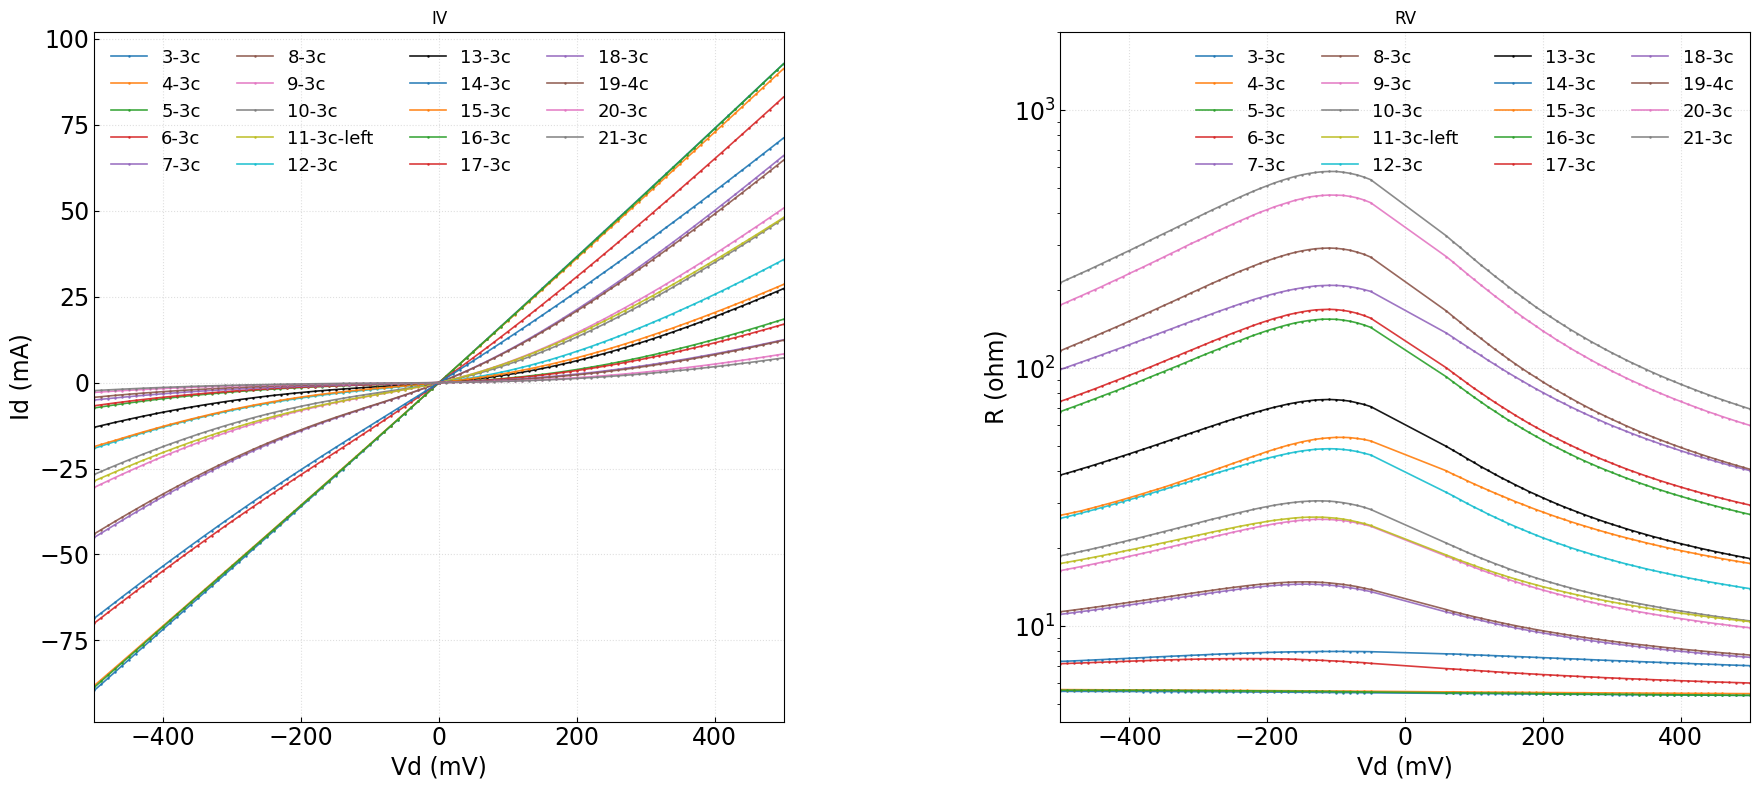

In [7]:
# 番号付き ivdata_path_k / ivlabel_k から読み込み → プロット（実行用）
max_k = 50  # 探索上限。必要に応じて増減可

paths: list[str] = []
labels: list[str] = []

for k in range(1, max_k + 1):
    p = globals().get(f"ivdata_path_{k}", "")
    if isinstance(p, str) and p:
        paths.append(p)
        lbl = globals().get(f"ivlabel_{k}", f"label {k}")
        if not isinstance(lbl, str):
            raise ValueError(f"ivlabel_{k} は文字列である必要があります")
        labels.append(lbl)

if not paths:
    raise ValueError("有効な ivdata_path_k が見つかりませんでした。")
if len(paths) != len(labels):
    raise ValueError("paths と labels の数が一致しません。")

# 読み込み
ids_series: list[list[float]] = []
vds_series: list[list[float]] = []
rs_series: list[list[float]] = []

for p in paths:
    ids_mA, vds_mV, rs_ohm = load_iv_data(p)
    ids_series.append(ids_mA)
    vds_series.append(vds_mV)
    rs_series.append(rs_ohm)

# プロット（その他オプションは自動）
label_indices = list(range(1, len(paths) + 1))
fig, ax_iv, ax_rv = plot_iv_rv_by_index(
    label_indices=label_indices,
    ids_series=ids_series,
    vds_series=vds_series,
    rs_series=rs_series,
    legend_labels=labels,
    rv_ylim=(0, 2000),
)


### 250918 Mg0nm SiN11

In [8]:
a2d_ivdata_path_1='/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 8-3c 300K Mg8nm SiNmiddle'
a2d_ivlabel_1="8-3c"    
a2d_ivdata_path_2='/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 8-6c 300K Mg4nm SiNmiddle'
a2d_ivlabel_2="8-6c"
a2d_ivdata_path_3="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 8-10c 300K Mg2nm SiNmiddle"
a2d_ivlabel_3="8-10c"
a2d_ivdata_path_4="/Volumes/NO NAME/20250918 CoFe 3T/IV/250926/IV 8-14c 300K Mg1nm SiNmiddle"
a2d_ivlabel_4="8-14c"


/var/folders/qf/6pgf31qx2cx6313dyyz9spz40000gn/T/ipykernel_96794/4189345409.py:163: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  if rv_ylim is not None: ax_rv.set_ylim(rv_ylim)


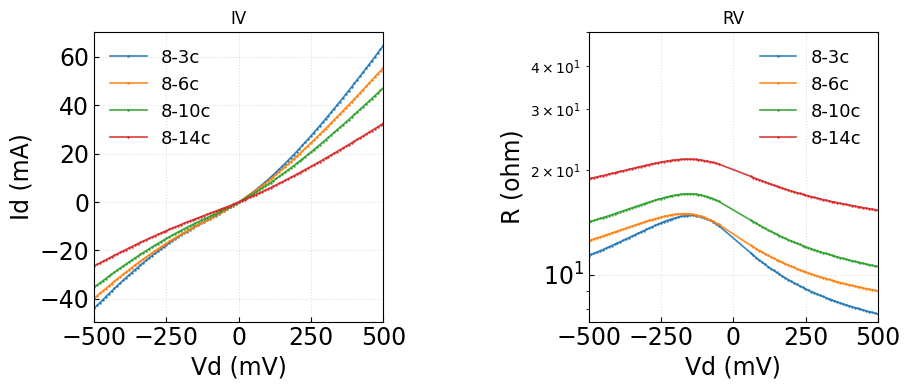

In [9]:
# 番号付き ivdata_path_k / ivlabel_k から読み込み → プロット（実行用）
max_k = 50  # 探索上限。必要に応じて増減可

paths: list[str] = []
labels: list[str] = []

for k in range(1, max_k + 1):
    p = globals().get(f"a2d_ivdata_path_{k}", "")
    if isinstance(p, str) and p:
        paths.append(p)
        lbl = globals().get(f"a2d_ivlabel_{k}", f"label {k}")
        if not isinstance(lbl, str):
            raise ValueError(f"ivlabel_{k} は文字列である必要があります")
        labels.append(lbl)

if not paths:
    raise ValueError("有効な ivdata_path_k が見つかりませんでした。")
if len(paths) != len(labels):
    raise ValueError("paths と labels の数が一致しません。")

# 読み込み
ids_series: list[list[float]] = []
vds_series: list[list[float]] = []
rs_series: list[list[float]] = []

for p in paths:
    ids_mA, vds_mV, rs_ohm = load_iv_data(p)
    ids_series.append(ids_mA)
    vds_series.append(vds_mV)
    rs_series.append(rs_ohm)

# プロット（その他オプションは自動）
label_indices = list(range(1, len(paths) + 1))
fig, ax_iv, ax_rv = plot_iv_rv_by_index(
    label_indices=label_indices,
    ids_series=ids_series,
    vds_series=vds_series,
    rs_series=rs_series,
    legend_labels=labels,
    figsize=(10, 4),
    rv_ylim=(0, 50),
)


# Hanle

## Hanle raw dataのロードとプロット

### 関数のインポート

In [10]:
from src import read_hanle_raw_data, plot_hanle_by_index

### 使用例

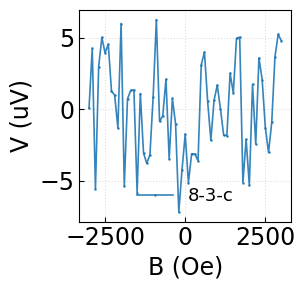

In [20]:
file_path = '/Volumes/NO NAME/20250918 CoFe 3T/Hanle/250926/20250926_165455 Hanle 8-3c Mg8nm 300K 3000-100 90deg -60mA 0.66V 0.50V_averaged'
magnetic_field, voltage = read_hanle_raw_data(file_path)
fig, ax = plot_hanle_by_index(
    label_indices=1,
    magnetic_field_series=[magnetic_field],
    voltage_series=[voltage],
    legend_labels=["8-3-c"],
    figsize=(10, 3),
)


## Hanle BroadとNarrowのロードとプロット

### 関数のimport

In [12]:
from src import read_hanle_broad, read_hanle_n_only, plot_hanle_broad_and_narrow

Test: (A_b3t, W_b3t, A_n3t, W_n3t, Ts, Voff_b, Voff_n, yokozure, alpha)
(7.592923e-05, 10723.69, 7.571629e-06, 49.88799, 1.138359e-09, -7.536539e-05, -7.991889e-05, 0.0, 0.0)


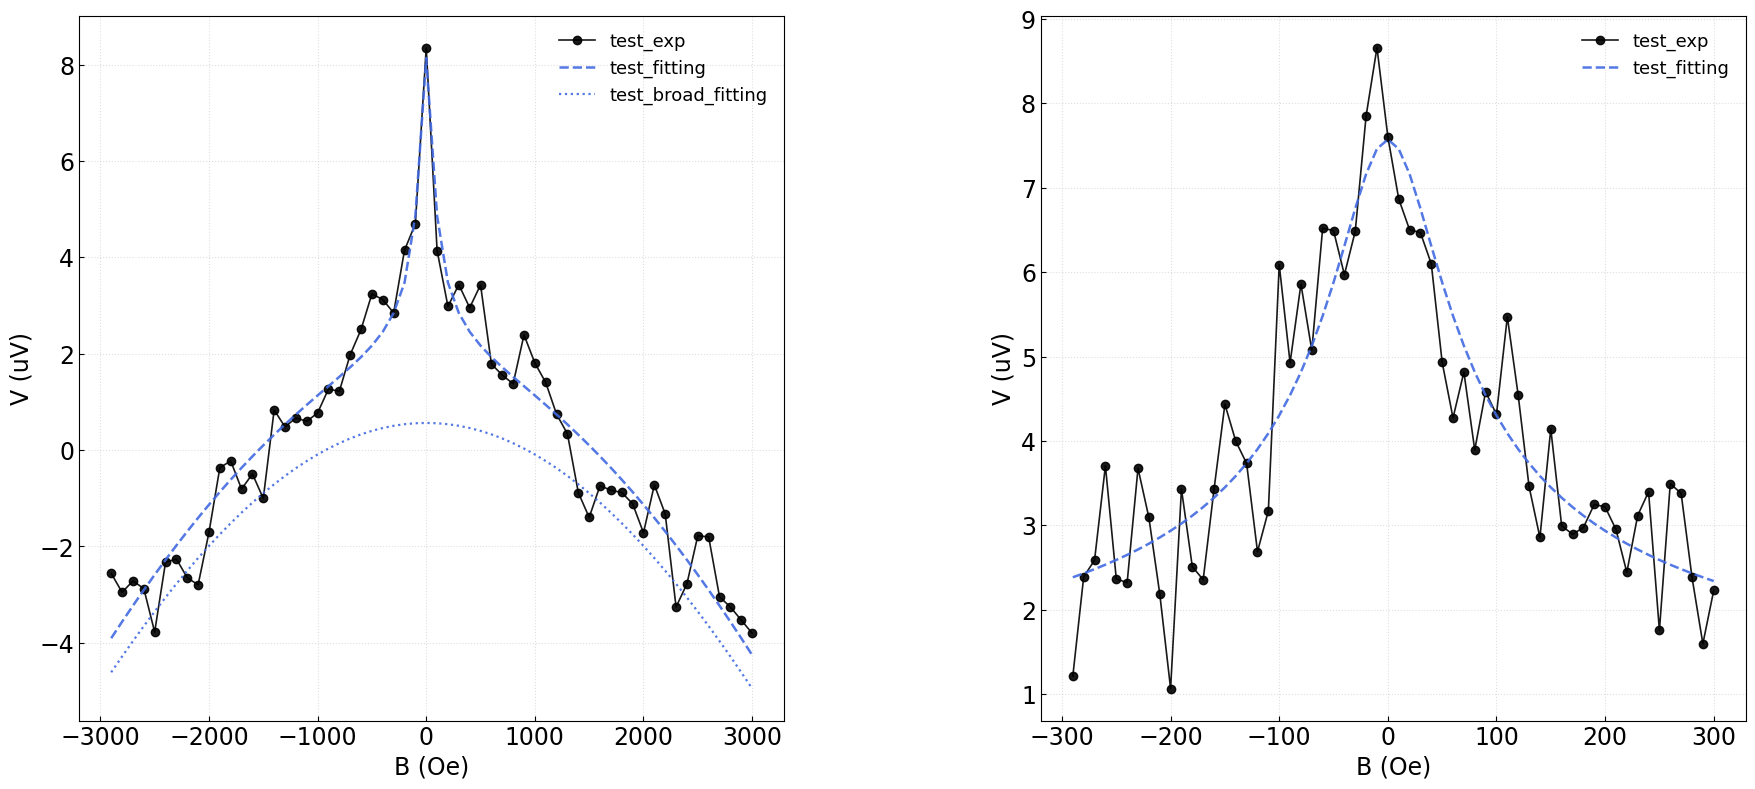

In [13]:
### 使用例
broad_file_path = "expdata-plotter/sample_data/Hanle_after_fitting/N3T_B3T_fitting_20250930_090655_20250929_115514 Hanle 8-10c Mg2nm 300K 300-10 90deg -30mA 0.44V 0.35V_averaged_B.txt"
narrow_file_path = "expdata-plotter/sample_data/Hanle_after_fitting/N3T_B3T_fitting_20250930_090655_20250929_115514 Hanle 8-10c Mg2nm 300K 300-10 90deg -30mA 0.44V 0.35V_averaged_N_only.txt"
fitting_info, broad_exp, broad_fitting, broad_broad_fitting = read_hanle_broad(broad_file_path)
print("Test: (A_b3t, W_b3t, A_n3t, W_n3t, Ts, Voff_b, Voff_n, yokozure, alpha)")
print(fitting_info)
narrow_exp, narrow_fitting = read_hanle_n_only(narrow_file_path)
fig, braod_ax, narrow_ax = plot_hanle_broad_and_narrow(
    broad_exp_data_series=[broad_exp],
    broad_fitting_data_series=[broad_fitting],
    broad_broad_fitting_series=[broad_broad_fitting],
    narrow_exp_data_series=[narrow_exp],
    narrow_fitting_data_series=[narrow_fitting],
    labels=["test"],
)